<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
![caption]('http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg')

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import re
sns.set()

In [2]:
# !pip install seaborn plotly --upgrade

In [3]:
# Поменяйте на свой путь к данным
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    PATH_TO_DATA = '/content/drive/My Drive/ML\DS/Yandex_MIPT_coursera/Course6/Final1/capstone_user_identification/'
else:
    PATH_TO_DATA = 'capstone_user_identification/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
from tqdm import tqdm

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    files = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    file_names = [name for name in sorted(os.listdir(path_to_csv_files)) if not name.startswith('.')]
    pattern = re.compile(r'\d+')
    user_ids = [int(re.search(pattern, n).group(0)) for n in file_names]
    
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)

    sessions = []
    durations = []
    timespans = []
    unique_sites = []
    start_hours = []
    days_of_week = []
    ids = []

    for ind, file in tqdm(enumerate(files)):
        f = pd.read_csv(file, parse_dates=[0])
        # Разбиваем файл на части размера "session_length" скользящим окном
        row = [f.site.values[i:i+session_length] for i in range(0, len(f), window_size)]
        # Получаем количество уникальных сайтов в каждой сессии в файле
        num_unique = list(map(lambda x: len(set(x)), row))
        # Получаем первое и последнее время для каждой сессии
        timestamps = [f.timestamp.values[i:i+session_length]
                       for i in range(0, len(f), window_size)]
        # Получаем продолжительности сессий, час начала и день недели
        diffs = list(map(lambda x: np.diff(x) // np.timedelta64(1, 's'), timestamps))
        timespan = [(x[-1] - x[0]) // np.timedelta64(1, 's') for x in timestamps]
        hour = list(map(lambda x: pd.Timestamp(x[0]).hour, timestamps))
        dow = list(map(lambda x: pd.Timestamp(x[0]).dayofweek, timestamps))
        
        # Создаём строки и столбцы будущего DataFrame
        sessions.extend(row)
        durations.extend(diffs)
        timespans.extend(timespan)
        unique_sites.extend(num_unique)
        start_hours.extend(hour)
        days_of_week.extend(dow)
        ids.extend([user_ids[ind]] * len(row))

    # Создаём DataFrame из сессий и заменяем имена сайтов их id в порядке убывания частот
    df = pd.DataFrame(sessions)
    df = df.applymap(lambda x: site_freq.get(x, [None])[0]).fillna(0).astype(int)

    # Добавляем остальные созданные столбцы и даём им имена
    durations_df = pd.DataFrame(durations).fillna(0).astype(int)
    other_features_df = pd.DataFrame(np.stack([timespans, unique_sites,
                                                start_hours, days_of_week, ids], axis=1)) 

    df = pd.concat([df, durations_df, other_features_df], axis=1)
    df.columns = feature_names

    return df

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

3it [00:00, 19.79it/s]


In [6]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      3      2      2      7      2      1      8      5      9      10   
1      3      1      1      1      0      0      0      0      0       0   
2      3      2      6      6      2      0      0      0      0       0   
3      4      1      2      1      2      1      1      5     11       4   
4      4      1      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(
                         path_to_csv_files=os.path.join(PATH_TO_DATA, '10users'), 
                         site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                         feature_names=feature_names,
                         session_length=10)

10it [00:00, 19.21it/s]

CPU times: user 626 ms, sys: 16 ms, total: 642 ms
Wall time: 644 ms


In [8]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    574    133      3    133    133      3    133    203     133   
1    415    193    674    254    133     31    393   3305    217      55   
2     55      3     55     55      5    293    415    333    897      55   
3    473   3306    473     55     55     55     55    937    199     123   
4    342     55      5   3307    258    211   3308   2086    675    2086   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week  target  
0           8            4      31  
1           8            4      31  
2           8            4      31  
3           8            4      31  
4           8            4      31

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe(
                         path_to_csv_files=os.path.join(PATH_TO_DATA, '150users'), 
                         site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                         feature_names=feature_names,
                         session_length=10)

150it [00:05, 28.70it/s]


CPU times: user 6.11 s, sys: 187 ms, total: 6.3 s
Wall time: 6.39 s


In [10]:
train_data_150users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      1      4      2      1      4      1      2   1290     321   
1      2     23   1505   1290    321    321    113     73     49      49   
2    321    205      1      1      1      1     73    321      2       1   
3      1      1   6998   6998   5491   6998   6998      1     35       1   
4      1      1     76      1     58     50     58     50     83      76   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0           1           1           1           4           0           1   
1           0           0          26           1          10          73   
2           1          10           1           5          16          56   
3           1           0           1           0         118         420   
4           4           3           0           1           0           1   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0          49           0                57              5   
1           0        1504           4              1618              8   
2        1917           0           4              2010              5   
3        1460           6           0              2006              4   
4           0           1           0                10              5   

   start_hour  day_of_week  target  
0           8            4       6  
1           8            4       6  
2           8            4       6  
3           9            4       6  
4           9            4       6

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [13]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [14]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [15]:
import plotly.express as px
from IPython.display import HTML

In [16]:
def draw_hist(data, color_list, hue=None, xlabel='x', ylabel='y', title=None, legend=False):
    '''
    Рисует ploly гистограмму
    '''
    fig = px.histogram(data, color=hue, color_discrete_sequence=color_list, width=800, height=500)
    # Рисуем белый контур у бинов, чтобы выглядело красивее
    fig.update_traces(marker=dict(line=dict(width=1, color='white')))
    
    fig.update_layout(showlegend=legend,
                      xaxis=dict(title=dict(text=xlabel)),
                      yaxis=dict(title=dict(text=ylabel)),
                      title=dict(text=title, x=0.5))

    fig.show()

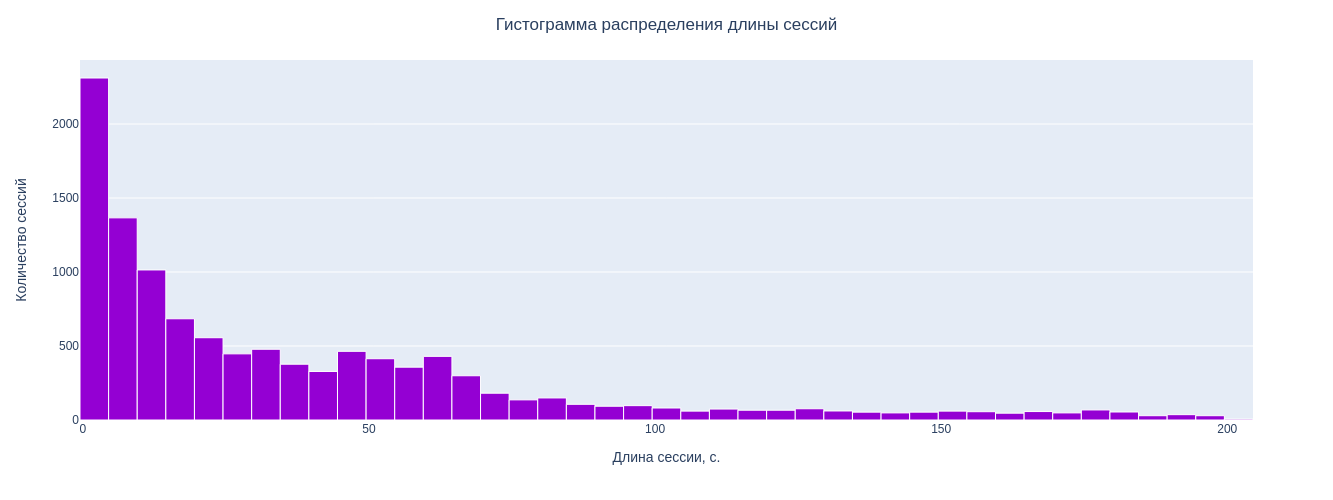

In [17]:
limited_timespan = train_data_10users['session_timespan'][train_data_10users['session_timespan'] <= 200]
draw_hist(data=limited_timespan,
          color_list=['darkviolet'],
          xlabel='Длина сессии, с.',
          ylabel='Количество сессий',
          title='Гистограмма распределения длины сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

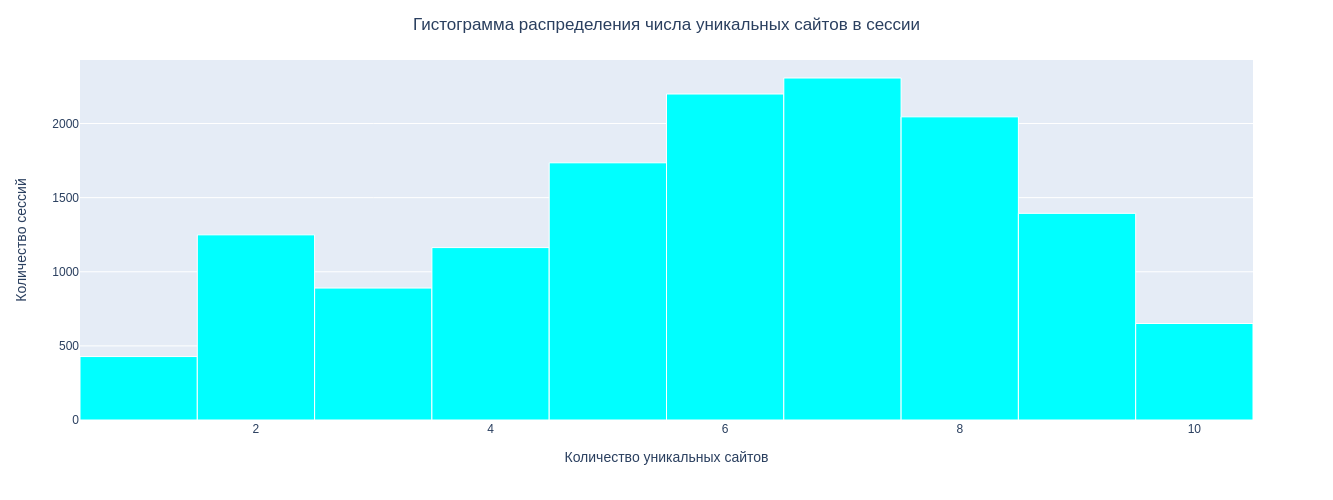

In [18]:
draw_hist(data=train_data_10users['#unique_sites'],
          color_list=['aqua'],
          xlabel='Количество уникальных сайтов',
          ylabel='Количество сессий',
          title='Гистограмма распределения числа уникальных сайтов в сессии')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [19]:
def draw_10_plots(data, names, colors, xlabel=None, ylabel=None, custom_ticks=None, title=None):
    fig = plt.figure(figsize=(22, 10))
    for idx, name in enumerate(names, start=1):
        ax = fig.add_subplot(3, 4, idx)
        sns.histplot(data[name], kde=False, color=colors[name], label=name, discrete=True)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        
        if custom_ticks:
            plt.xticks(list(custom_ticks.keys()), list(custom_ticks.values()))
            
        if title:
            plt.title(title + ' для ' + name)
            
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [20]:
user_unique_sites = train_data_10users.groupby('target')['#unique_sites'].agg(list)
user_names = user_unique_sites.index

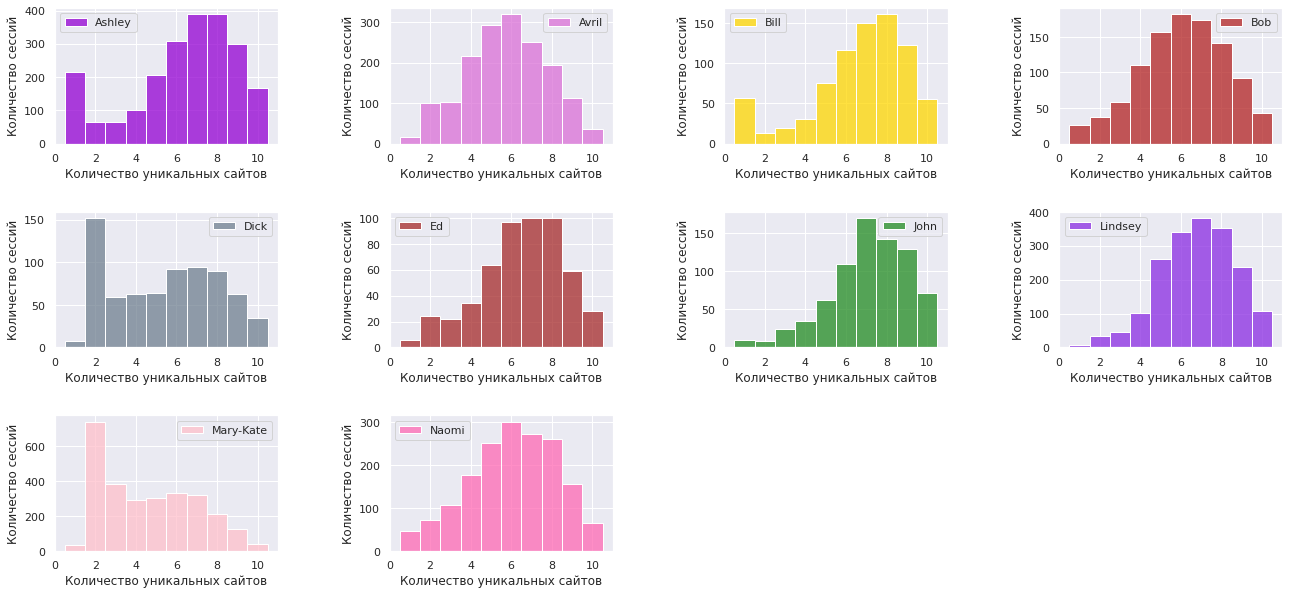

In [21]:
# Plotly не умеет показывать легенду на каждом subplot, поэтому пришлось использовать seaborn
draw_10_plots(user_unique_sites, user_names, color_dic,
              xlabel='Количество уникальных сайтов',
              ylabel='Количество сессий')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

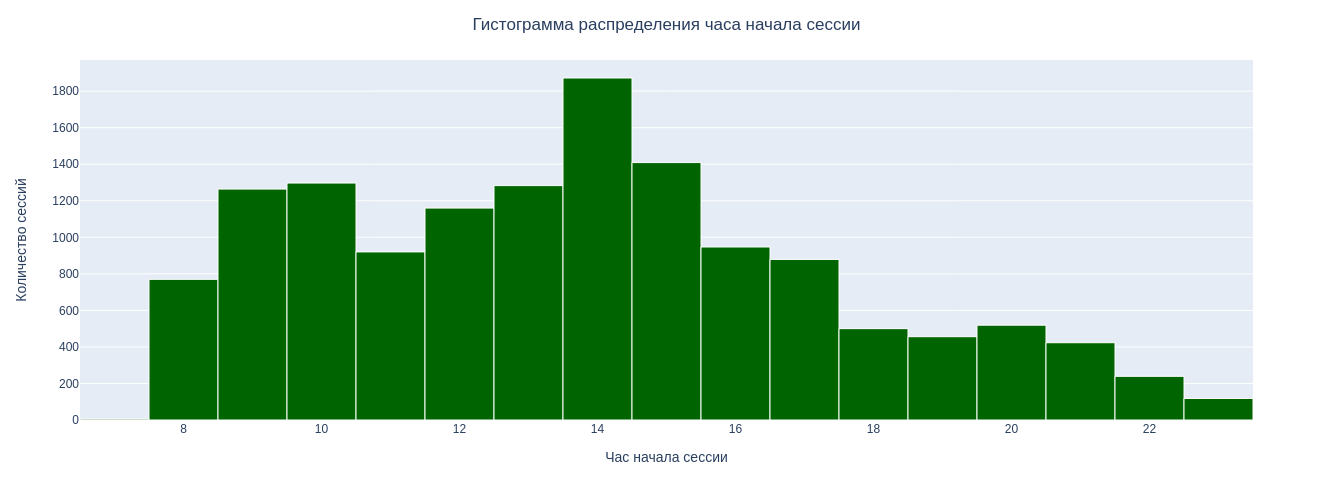

In [22]:
draw_hist(train_data_10users['start_hour'], color_list=['darkgreen'],
         xlabel='Час начала сессии', ylabel='Количество сессий',
         title='Гистограмма распределения часа начала сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

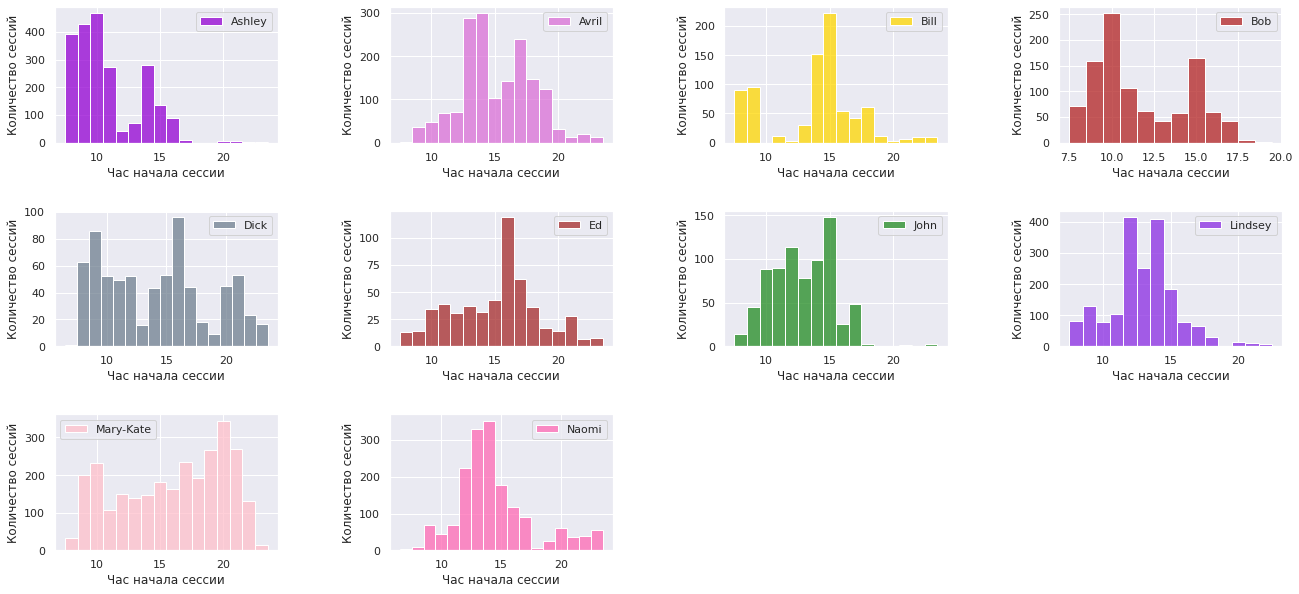

In [23]:
user_start_hour = train_data_10users.groupby('target')['start_hour'].agg(list)
draw_10_plots(user_start_hour, user_names, color_dic,
              xlabel='Час начала сессии',
              ylabel='Количество сессий')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

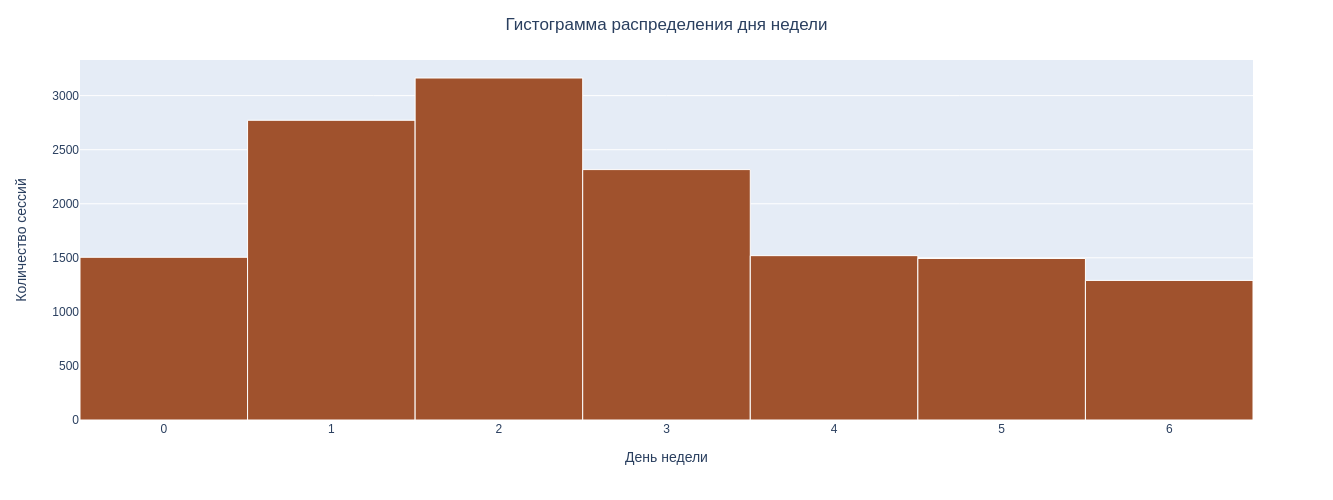

In [24]:
draw_hist(train_data_10users['day_of_week'], color_list=['sienna'],
          xlabel='День недели', ylabel='Количество сессий',
          title='Гистограмма распределения дня недели')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

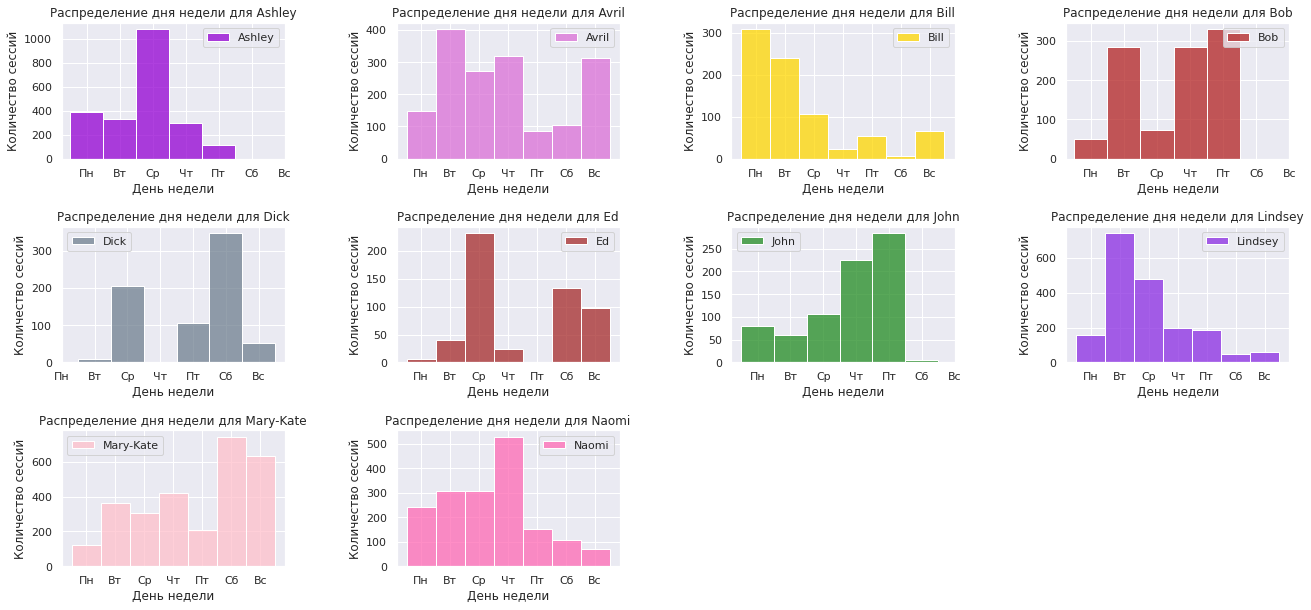

In [25]:
ticks = {0:'Пн', 1:'Вт', 2:'Ср', 3:'Чт', 4:'Пт', 5:'Сб', 6:'Вс'}
user_dow = train_data_10users.groupby('target')['day_of_week'].agg(list)
draw_10_plots(user_dow, user_names, color_dic,
              xlabel='День недели',
              ylabel='Количество сессий',
              title='Распределение дня недели',
              custom_ticks=ticks)

Построим ещё распределение количества сессий по пользователю, чтобы узнать, кто из них чаще заходит в интернет.

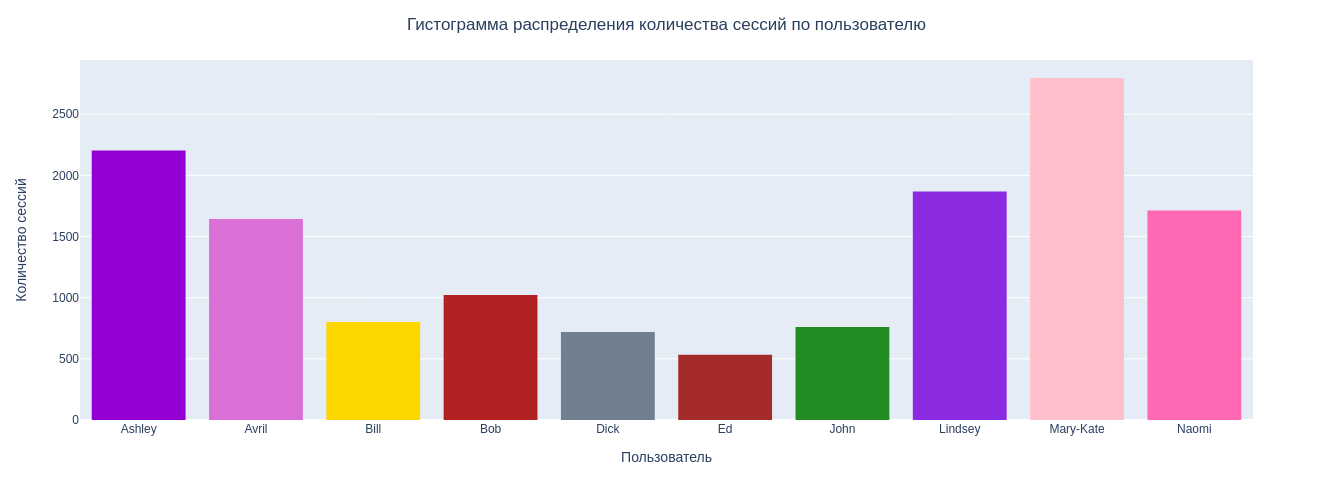

In [26]:
fig = px.histogram(train_data_10users, x='target', y='day_of_week', color='target',
                   color_discrete_map=color_dic, histfunc='count',
                   category_orders={'target': sorted(user_names)},
                   width=800, height=500)

fig.update_layout(showlegend=False,
                  xaxis=dict(title=dict(text='Пользователь')),
                  yaxis=dict(title=dict(text='Количество сессий')),
                  title=dict(text='Гистограмма распределения количества сессий по пользователю', x=0.5))
fig.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**1. Ashley**.

Имеет довольно много сессий в интернете и за каждую сессию чаще всего заходит на 7-8 уникальных сайтов, но есть выделяющийся пик на 1 сайте в сессии, возможно заходит проверить почту. Большинство её сессий приходится на среду. Возможно по средам она себе выделяет день, когда можно посидеть в интернете, либо это связано с работой (можно было бы посмотреть на какие сайты она в это время заходит). А вот в выходные она практически не заходит в интернет совсем. Скорее всего проводит выходные с друзьями или просто гуляет. Больше всего её сессий приходится на утро, с 8 до 11 часов. Вероятно, проверяет почту с утра, смотрит погоду, заходит в соцсети. Также есть выделяющийся пик на 14 часов, что скорее всего соответствует её обеденному времени.

**2. Avril**.

Тоже активный пользователь интернета. Чаще всего за время сессии заходит на 6 уникальных сайтов. Появляется в интернете каждый день, больше всего раз во вторник, среду и четверг. Возможно связано с работой. Также выделяет себе день для интернета в воскресенье. Больше всего сессий начинает в обеденное время 13-14 часов, а также вечером в 17.

**3. Bill**.

Имеет не очень много сессий в интернете. За их время заходит чаще всего на 8 разных сайтов, но есть небольшой пик на 1 сайте, который может быть связан с проверкой почты, погоды или соц сетей. Активен обычно в начале недели в понедельник и вторник, в остальные дни заходит в интернет меньше. Часто начинает сессии в 15 часов, а также заходит с утра 8-9 часов.

**4. Bob**.

Тоже не очень активный пользователь интернета. Самое частое количество сайтов в сессии 6 и в принципе распределение похоже на нормальное. Чаще всего бывает в интернете во вторник, четверг и пятницу (странное сочетание), а в выходные вообще в интернет не заходит. Обычно начинает сессии в 10 и 15 часов, что может соответствовать началу рабочего дня и обеденному перерыву.

**5. Dick**.

Редко заходит в интернет. Количество уникальных сайтов в сессии чаще всего 2. Что-то вроде сочетания погода + почта. На неделе выделяет себе субботу, чтобы посидеть в интернете, также активен в среду, но практически совсем не заходит в интернет в понедельник и четверг. Начинает сессии в совершенно разное время дня, но чаще всего в 9 и 16 часов.

**6. Ed**.

Самое маленькое количество сессий из расматриваемых 10 человек. Сессии обычно состоят из 7-8 сайтов. Во время рабочей недели с понедельника по пятницу заходит в основном только в среду, зато активен на выходных. Чаще всего начинает сессии в 16 часов, остальное время ничем не выделяется.

**7. John**.

Тоже является одним из неактивных пользователей. Обычное количество разных сайтов в сессии 7. Более менее активен в интернете во время рабочей недели с пиком в пятницу, а в выходные от интернета отдыхает. Начинает сессии в течение рабочего дня, чаще всего в 15 часов, и практически вообще не заходит в интернет вечером после 17. Возможно, во время работы Джону скучно, и он заходит посидеть в интернете время от времени, а после работы уже находит себе другое занятие.

**8. Lindsey**.

Довольно активный пользователь интернета. Большинство сессий состоят из 7 разных сайтов. Понемногу заходит в интернет каждый день, но чаще всего во вторник и среду, может у неё это выходные. Пик активности в течение дня приходится на обеденный перерыв 12 и 14 часов, а вот вечером пользуется интернетом нечасто.

**9. Mary-Kate**.

Обладает самым большим количеством сессий, но пик уникальных сайтов в сессии равен 2. Активна в интернете в течение всей недели, но очень много в нём сидит на выходных в субботу и воскресенье. Начинает сессии в интернете в течение всего дня, но чаще всего вечером в 20 часов, а также с утра 9-10 часов. Скорее всего не любит активный отдых и предпочитает сидеть дома и общаться с друзьями в интернете. Возможно очень активный пользователей соцсетей.

**10. Naomi**.

Довольно активно пользуется интернетом. Распределение уникалных сайтов похоже на нормальное с пиком в 6. Больше пользуется интернетом в будние дни, особенно в четверг, а вот в выходные меньше. Пик активности в течение дня приходится на обед в 14 часов, а также любит посидеть в интернете вечером перед сном.

*Забавно получилось, что в этой выборке девушки чаще сидят в интернете, чем мужчины, хотя имена выбраны совершенно случайно.*

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [27]:
with open (os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'br') as f:
    site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [28]:
top10_sites, top10_freqs = [], []
for i, (site, freq) in enumerate(site_freq_10users.items()):
    if i == 10:
        break
    top10_sites.append(site)
    top10_freqs.append(freq[1])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

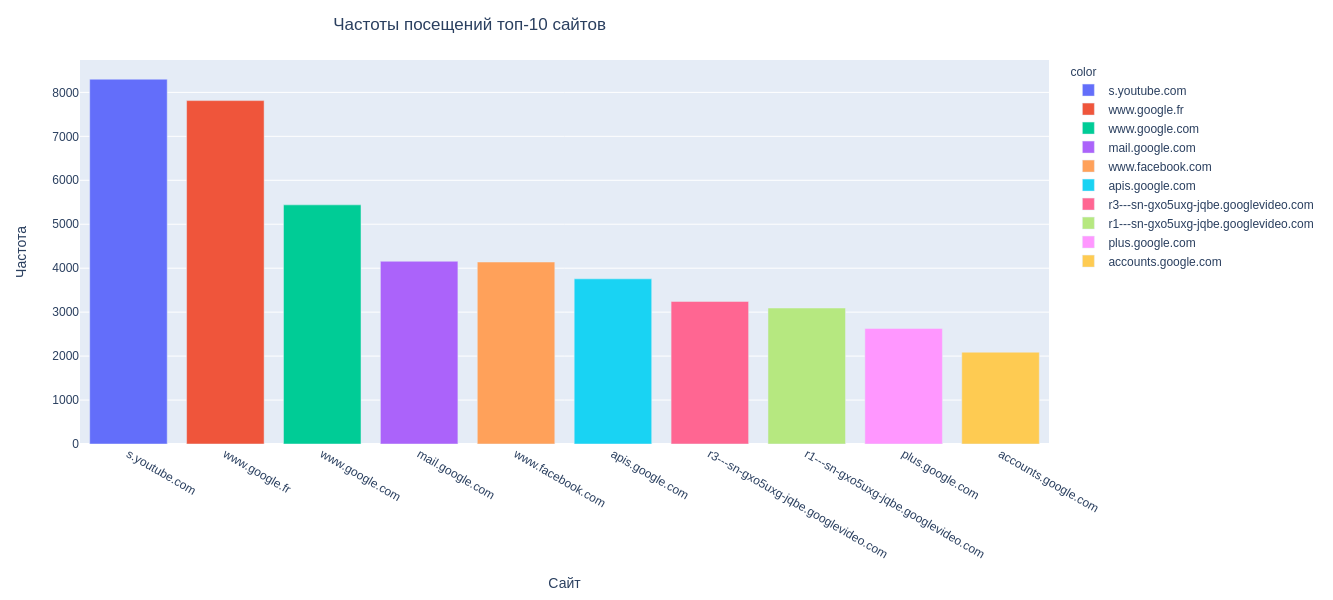

In [29]:
# Воспользуемся plotly, а не seaborn
fig = px.bar(x=top10_sites, y=top10_freqs, color=top10_sites,
             width=1000, height=600)

fig.update_layout(showlegend=True,
                  xaxis=dict(title=dict(text='Сайт')),
                  yaxis=dict(title=dict(text='Частота')),
                  title=dict(text='Частоты посещений топ-10 сайтов', x=0.25))

fig.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [30]:
median_session_timespan_10 = train_data_10users.session_timespan.median()
print(f'Медианная продолжительность сессии (10 пользователей) \
= {median_session_timespan_10} секунд')

Медианная продолжительность сессии (10 пользователей) = 37.0 секунд


**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [31]:
median_day_of_week_10 = train_data_10users.day_of_week.median().astype(int)
print(f'Медианный день недели (10 пользователей) \
— {median_day_of_week_10} ({ticks[median_day_of_week_10]})')

Медианный день недели (10 пользователей) — 2 (Ср)


**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [32]:
median_start_hour_150 = train_data_150users.start_hour.median()
print(f'Медианный час начала сессии (150 пользователей) \
= {median_start_hour_150}')

Медианный час начала сессии (150 пользователей) = 13.0


**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [33]:
median_unique_sites_150 = train_data_150users['#unique_sites'].median()
print(f'Медианное значение числа уникальных сайтов (150 пользователей) \
= {median_unique_sites_150}')

Медианное значение числа уникальных сайтов (150 пользователей) = 7.0


## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Думаю, имеет смысл создать категорию времени суток, так как сам по себе час начала мало значим, а вот утро, день или вечер будет иметь больше информации.

Также можно создать индикатор выходного дня, так как в предыдущем задании было видно, что некоторые люди больше активны в будни, либо наоборот. При этом стоит сам по себе день недели закодировать one-hot encoding, иначе модель будет считать, например, что вторник более весомый, чем понедельник, а среда более весомая, чем вторник, и.т.д.

Создать индикатор посещения сайтов соц. сетей.

Ещё можно попробовать посмотреть, сколько времени от сессии занимает просмотр популярных сайтов и соцсетей и взять их отношение к времени сессии.

**1. Построим признак времени суток.**

In [34]:
train_data_10users.start_hour.describe(percentiles=[])

count    14061.000000
mean        13.768366
std          3.681279
min          7.000000
50%         14.000000
max         23.000000
Name: start_hour, dtype: float64

In [35]:
train_data_150users.start_hour.describe(percentiles=[])

count    137019.000000
mean         12.839373
std           3.288743
min           7.000000
50%          13.000000
max          23.000000
Name: start_hour, dtype: float64

Видим, что минимальное время начала сессий в 7 часов, а максимальное в 23. Поэтому будем разбивать этот промежуток времени на утро-день-вечер, и на всякий случай, если в новых данных появятся другие времена начала, промежуток с 0 до 6 часов пометим как "ночь". Возьмём интервалы 7-11, 12-17, 18-23 часов.

In [36]:
def build_time_of_day(data):
    '''
    Takes start hour and converts it to time_of_day
    0-6: night
    7-11: morning
    12-17: afternoon
    18-23: evening
    Returns new Series time_of_day
    '''
    tod = pd.Series([None] * len(data), name='time_of_day')
    tod[(data <= 23) & (data >= 18)] = 'evening'
    tod[(data <= 17) & (data >= 12)] = 'afternoon'
    tod[(data <= 11) & (data >= 7)] = 'morning'
    tod[(data <= 6) & (data >= 0)] = 'night'
    return tod

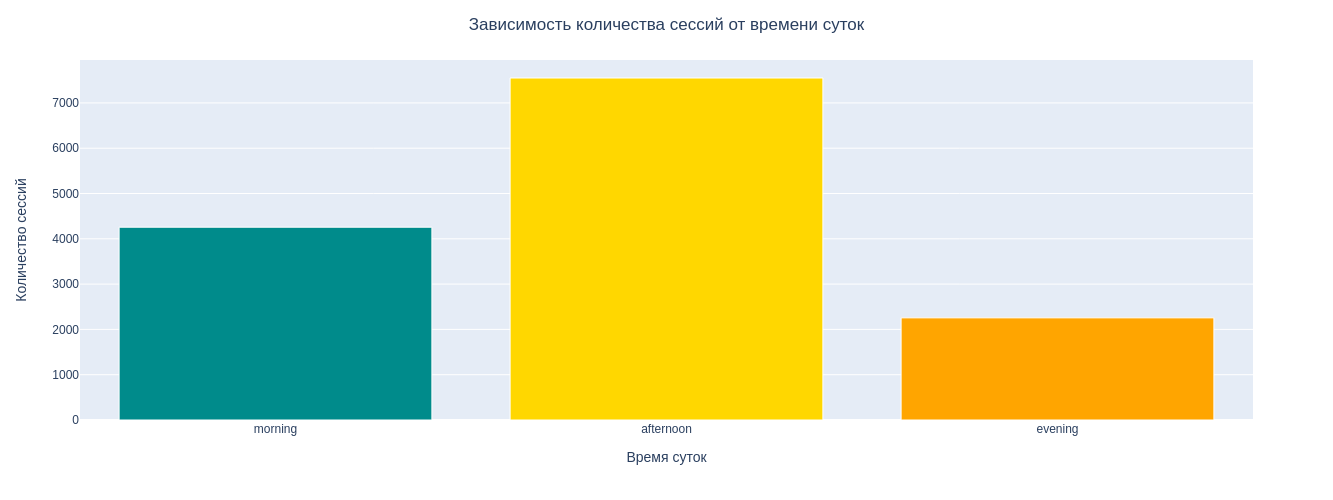

In [37]:
# Применим функцию для данных 10 пользователей и посмотрим картинки
time_of_day10 = build_time_of_day(train_data_10users.start_hour)
draw_hist(time_of_day10, hue=time_of_day10, color_list=['darkcyan', 'gold', 'orange'],
          xlabel='Время суток', ylabel='Количество сессий',
          title='Зависимость количества сессий от времени суток')

Из графика видно, что чаще всего пользователи заходят в интернет днём, а вот вечером предпочитают заниматься другими делами.

Посмотрим как это выглядит для каждого пользователя. Чтобы пока что не добавлять признак в основные данные, просто добавим к нему информацию о user_id

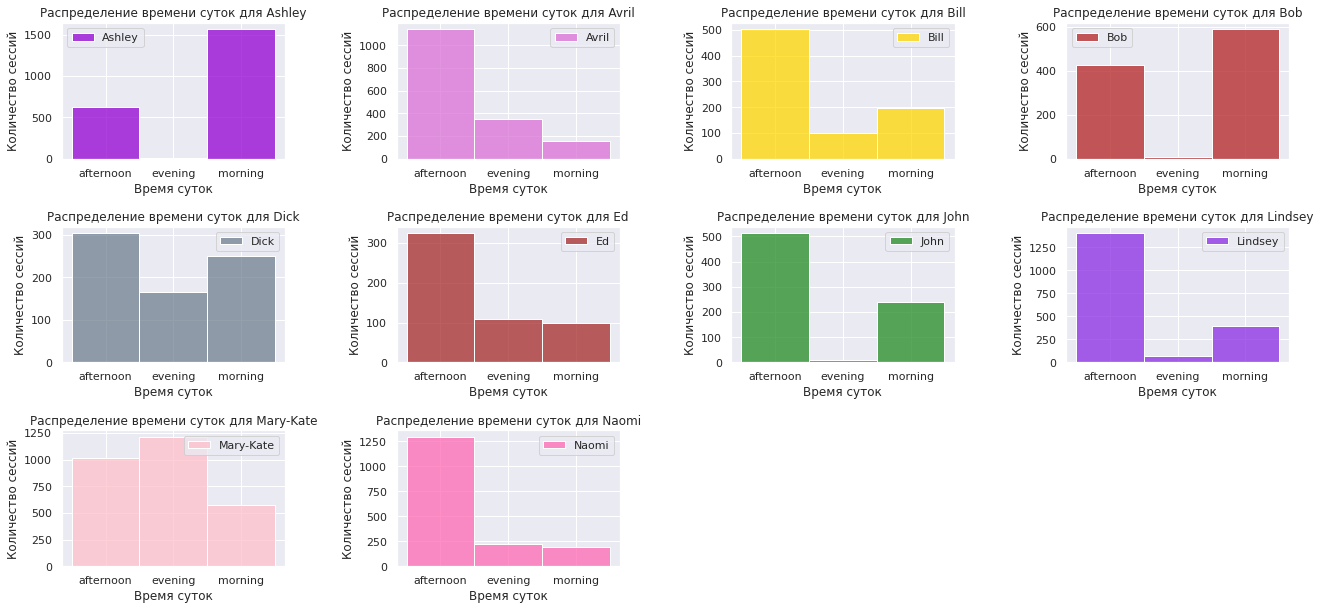

In [38]:
tod_df = pd.concat([time_of_day10, train_data_10users.target], axis=1)
user_tod = tod_df.groupby('target')['time_of_day'].agg(list)
draw_10_plots(user_tod.map(sorted), names=user_names, colors=color_dic,
              xlabel='Время суток', ylabel='Количество сессий',
              title='Распределение времени суток')

Видим, что картинки согласуются с предыдущей. Много пользователей часто начинают свои сессии днём, реже утром, и самое редкое вечером.

**2. Построим признак индикатора выходного дня**

In [39]:
def build_is_weekend(data):
    '''
    Takes day of week and checks if it's weekend day
    0-4: not weekend (0)
    5-6: weekend (1)
    Returns new Series is_weekend
    '''
    isw = pd.Series([0] * len(data), name='is_weekend', dtype=int)
    isw[(data <= 6) & (data >= 5)] = 1
    return isw

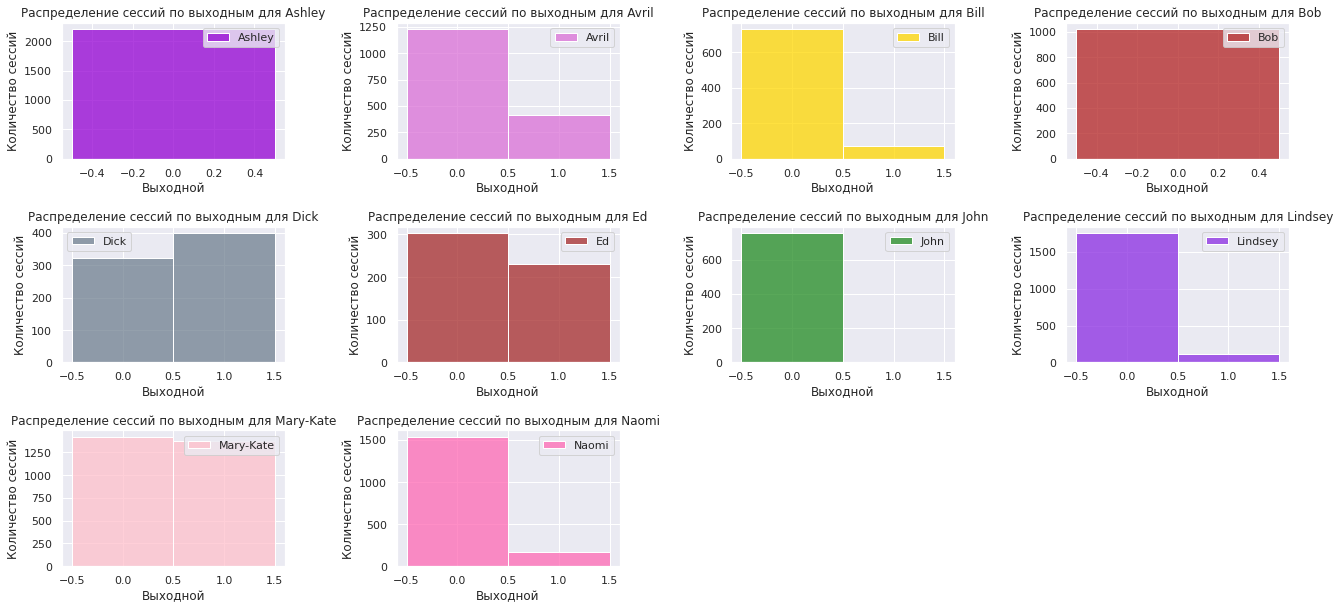

In [40]:
is_weekend10 = build_is_weekend(train_data_10users.day_of_week)
isw_df = pd.concat([is_weekend10, train_data_10users.target], axis=1)
user_isw = isw_df.groupby('target')['is_weekend'].agg(list)
draw_10_plots(user_isw, names=user_names, colors=color_dic,
              xlabel='Выходной', ylabel='Количество сессий',
              title='Распределение сессий по выходным')

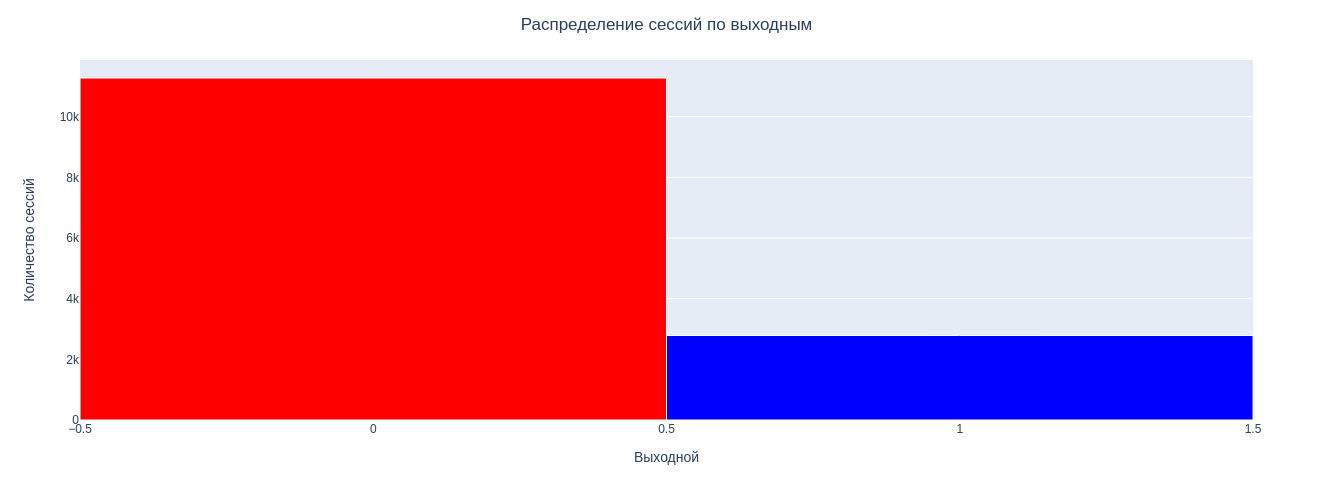

In [41]:
draw_hist(is_weekend10, hue=is_weekend10, color_list=['red', 'blue'],
          xlabel='Выходной', ylabel='Количество сессий',
          title='Распределение сессий по выходным')

На графиках можно увидеть, что мало пользователей предпочитают сидеть в интернете на выходных. Из всех 10 пользователей только Dick заходит в интернет на выходных чаще, чем в будни. У Mary-Kate и Ed разница между количеством сессий на выходных и в будни небольшая. Остальные заходят в интернет преимущественно в будние дни.

**3. Посмотрим сколько раз за сессию пользователь заходит на сайты соцсетей.**

В качестве таких сайтов рассмотрим facebook, youtube, instagram, twitter, а также все их производные, так как я при обработке данных не считал эти сайты одним.

In [42]:
def build_num_of_social(data, site_freq):
    '''
    Takes info about all visited sites in all user sessions and dict of sites frequencies.
    Returns Series with total number of social network sites visited (not unique!)
    Social networks: facebook, youtube, instagram and twitter
    '''
    # Найдём id сайтов соц. сетей
    pattern = re.compile(r'facebook|youtube|instagram|twitter')
    sites_ids = [val[0] for key, val in site_freq.items() if re.findall(pattern, key)]

    counts = data.apply(lambda x: dict(zip(*np.unique(x, return_counts=True))),axis=1)
    num_of_social = counts.apply(lambda x: np.sum([x.get(y) for y in sites_ids if y in x], dtype=int))
    num_of_social.name = '#social_networks'
    return num_of_social

In [43]:
num_of_social10 = build_num_of_social(train_data_10users.loc[:, 'site1':'site10'],
                                      site_freq_10users)
nos_df = pd.concat([num_of_social10, train_data_10users.target], axis=1)

Посмотрим на картинки

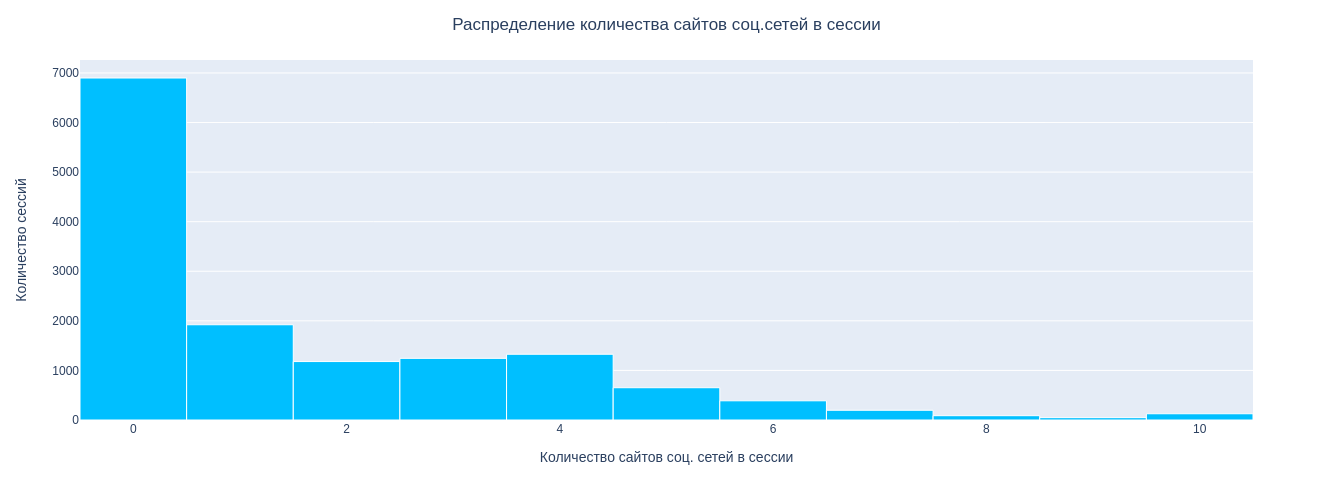

In [44]:
draw_hist(num_of_social10, color_list=['deepSkyBlue'],
          xlabel='Количество сайтов соц. сетей в сессии',
          ylabel='Количество сессий',
          title='Распределение количества сайтов соц.сетей в сессии')

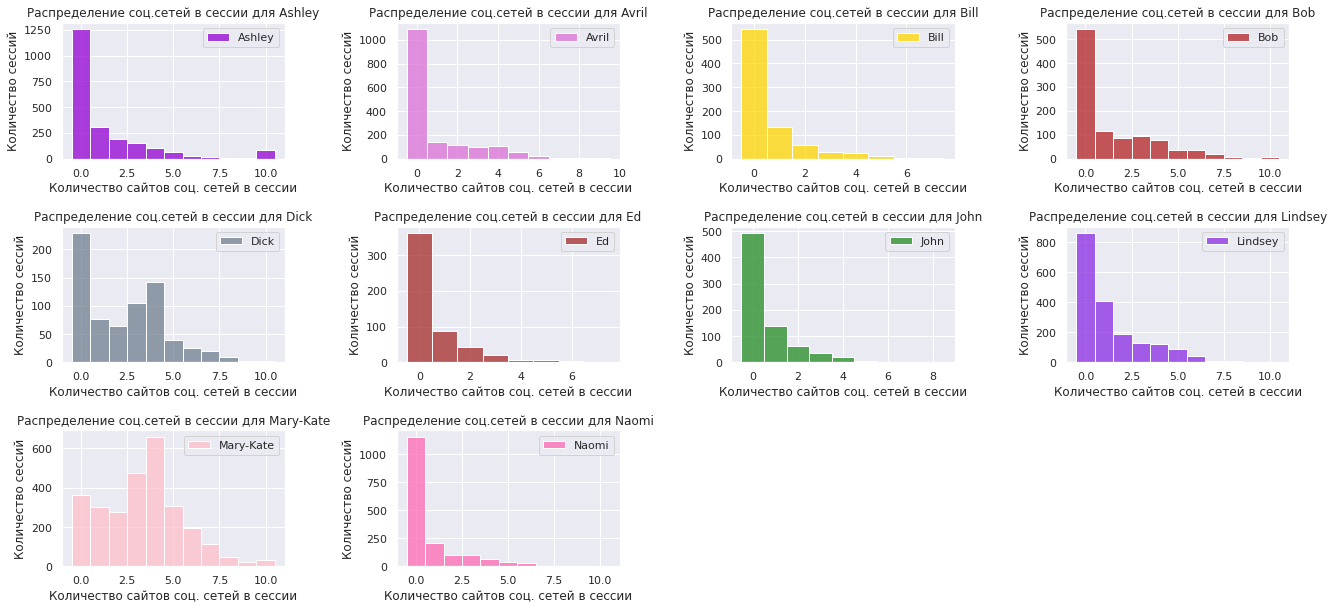

In [45]:
user_nos = nos_df.groupby('target')['#social_networks'].agg(list)
draw_10_plots(user_nos, names=user_names, colors=color_dic,
              xlabel='Количество сайтов соц. сетей в сессии', ylabel='Количество сессий',
              title='Распределение соц.сетей в сессии')

На графиках можно увидеть, что большинство пользователей ни разу не заходят на сайты соц.сетей за 10 сайтовую сессию. И в целом количество сессий с увеличением числа посещения соц. сетей уменьшается почти для всех пользователей, но есть те, кто выделяется. Например, Mary-Kate, которая, как мы выяснили раньше, является самым активным пользователем интернета, чаще всего бывает 4 раза на сайтах соц.сетей за 1 сессию. Dick тоже имеет знчительную часть сессий с 4 сайтами соц. сетей. Учитывая, что он очень любит заходить в интернет на выходных, возможно именно на них и приходятся такие сессии, а в будни он вероятно туда почти не заходит. Распределение Ashley похоже на распределение большинства, но у неё есть странный скачок на 10 сайтах соц. сетей в сессии. Видимо, она выделяет себе время, когда заходит в интернет исключительно ради соц. сетей. 

**4. Посмотрим на отношение проведённого времени на 30 самых популярных сайтах и в соц. сетях к общему времени сессии.**

In [46]:
def build_pop_total_ratio(sites, time_diffs, timespans, site_freq):
    '''
    Takes info about all visited sites in all user sessions, time spent on these sites,
    total session timespan and dict of sites frequencies.
    Returns Series with ratio of time spent on 30 most popular sites + social networks
    to total session timespan.
    Social networks: facebook, youtube, instagram and twitter
    '''
    from collections import defaultdict

    # Найдём id сайтов соц. сетей
    pattern = re.compile(r'facebook|youtube|instagram|twitter')
    sites_ids = [val[0] for key, val in site_freq.items() if re.findall(pattern, key)]

    # Поставим в соответствие каждому сайту время, в течении которого на нём находился пользователь
    add_zeros = np.hstack([time_diffs.values, np.zeros(time_diffs.shape[0]).reshape(-1, 1)])
    zipped = np.dstack([sites.values, add_zeros])

    # Создаём столбец данных
    s = pd.Series(data=[None]*len(zipped), name='pop_total_ratio')
    for i, row in enumerate(zipped):
        d = defaultdict(int)
        for k, v in row:
            d[k] += v
        res = np.sum([d.get(x) for x in set(range(30)).union(sites_ids) if x in d])
        s[i] = res / timespans[i]
    s.fillna(0, inplace=True)
    return s

In [47]:
sites_df = train_data_10users.loc[:, 'site1':'site10']
time_diffs_df = train_data_10users.loc[:, 'time_diff1':'time_diff9']
timespans = train_data_10users.session_timespan

In [48]:
pop_total10 = build_pop_total_ratio(sites_df, time_diffs_df, timespans, site_freq_10users)

/home/snake/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in double_scalars



Посмотрим на картинки

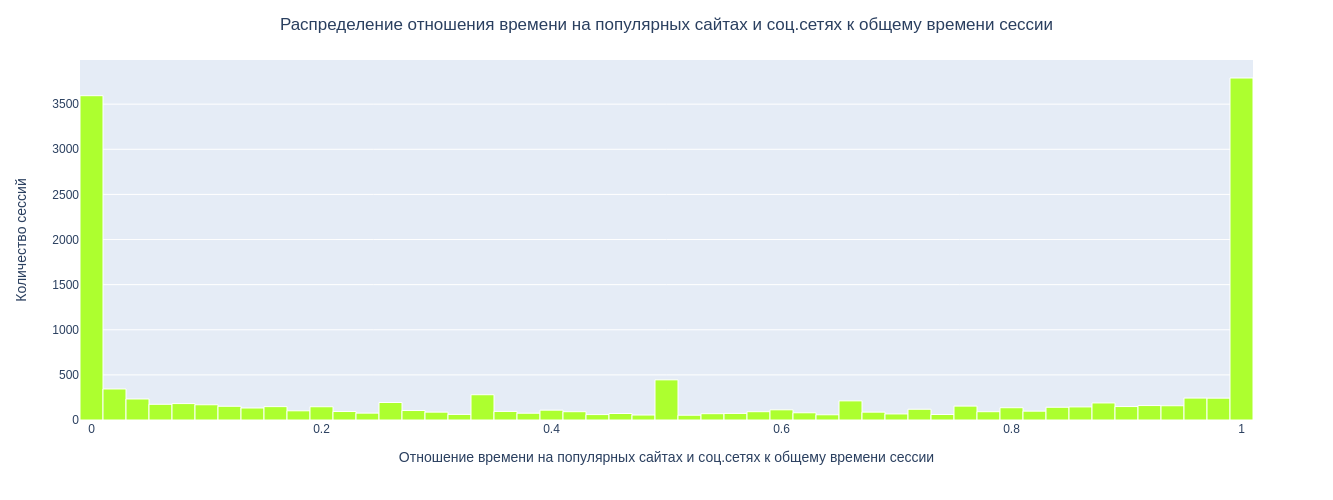

In [49]:
draw_hist(pop_total10, color_list=['greenYellow'],
          xlabel='Отношение времени на популярных сайтах и соц.сетях к общему времени сессии',
          ylabel='Количество сессий',
          title='Распределение отношения времени на популярных сайтах и соц.сетях к общему времени сессии')

In [50]:
ptr_df = pd.concat([pop_total10, train_data_10users.target], axis=1)
user_ptr = ptr_df.groupby('target')['pop_total_ratio'].agg(list)

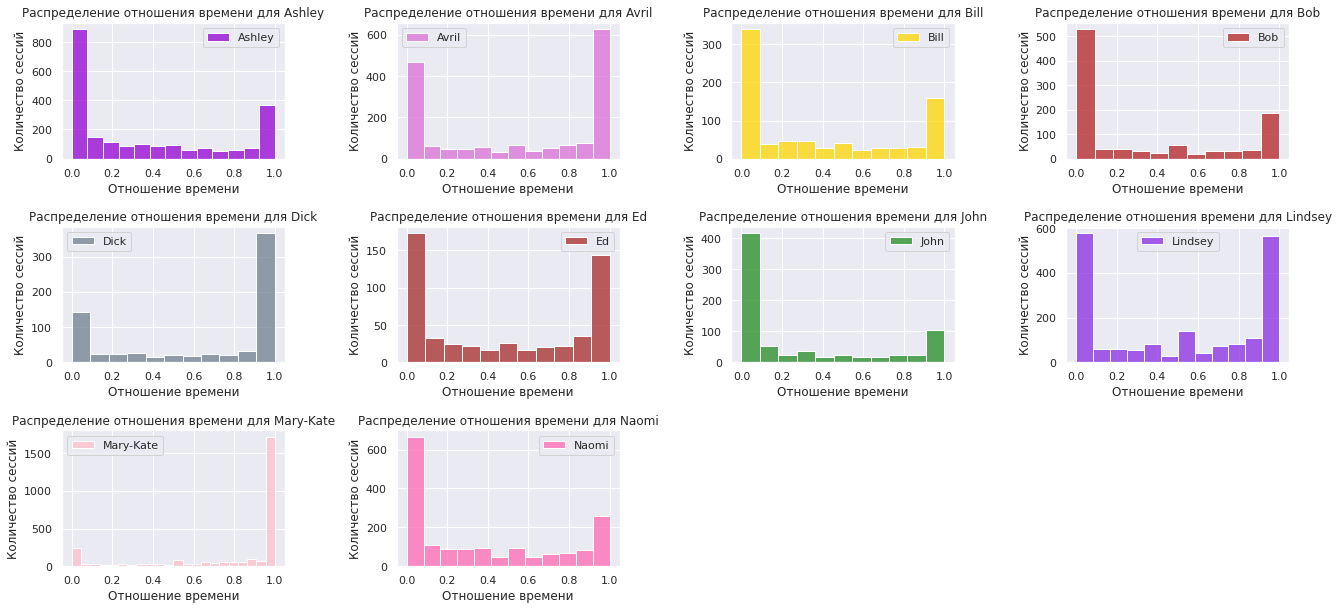

In [51]:
fig = plt.figure(figsize=(22, 10))
for idx, name in enumerate(user_names, start=1):
    ax = fig.add_subplot(3, 4, idx)
    sns.histplot(user_ptr[name], kde=False, color=color_dic[name], label=name)
    plt.xlabel('Отношение времени')
    plt.ylabel('Количество сессий')
    plt.legend()
    plt.title('Распределение отношения времени для ' + name)
        
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Судя по всему, признак не очень информативный. Пользователи очень часто либо вообще не проводят время на популярных сайтах и в соц. сетях либо проводят там всю сессию. Возможно, признак будет более информативен если выбрать другую длину сессии. Однако и из этих графиков можно узнать, кто чаще предпочитает популярные сайты. Например, Mary-Kate, Dick и Avril. Ed и Lindsey имеют почти одинаковое количество сессий как без популярных сайтов так и только из популярных. Остальные похоже предпочитают сидеть на менее популярных сайтах. 

Заполним предложенную функцию feature_engineering так, чтобы она выдавала все 4 построенные признака в одном DataFrame

In [52]:
def feature_engineering(data, site_freq_path):
    '''
    Use as an addition to function prepare_train_set_with_fe
    '''
    # Загружаем словарь частот сайтов
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)

    # Приготовим нужные части данных 
    sites = data.loc[:, 'site1':'site10']
    diffs = data.loc[:, 'time_diff1':'time_diff9']
    timespans = data.session_timespan
    start_hours = data.start_hour
    days_of_week = data.day_of_week

    # Строим признак времени суток
    time_of_day = build_time_of_day(start_hours)
    # Строим признак выходного дня
    is_weekend = build_is_weekend(days_of_week)
    # Строим признак количества посещённых соц. сетей
    num_of_social = build_num_of_social(sites, site_freq)
    # Строим признак отношения времени проведённого на популярных сайтах к времени сессии
    pop_total_ratio = build_pop_total_ratio(sites, diffs, timespans, site_freq)

    return pd.concat([time_of_day, is_weekend, num_of_social, pop_total_ratio], axis=1)

In [53]:
new_features_10users = feature_engineering(train_data_10users, os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))

/home/snake/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in double_scalars



In [54]:
%%time
new_features_150users = feature_engineering(train_data_150users, os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'))

/home/snake/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in double_scalars



CPU times: user 14.2 s, sys: 186 ms, total: 14.4 s
Wall time: 14.9 s


In [55]:
new_features_150users.head()

time_of_day  is_weekend  #social_networks  pop_total_ratio
0     morning           0                 0         1.000000
1     morning           0                 0         0.000000
2     morning           0                 0         0.040796
3     morning           0                 0         0.003490
4     morning           0                 0         0.800000

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**
## Уже сделал это выше. Совместил это с построением новых признаков, чтобы было более последовательное повествование.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

На мой взгляд, стоит оставить все старые признаки и те, которые создал я. Может быть излишним признак *start_hour*, так как новый признак *time_of_day* лучше разделяет пользователей. Сохраним все эти признаки сейчас на всякий случай, а выкинуть потом всегда успеем.

In [56]:
selected_features_10users = pd.concat([train_data_10users, new_features_10users], axis=1)
selected_features_150users = pd.concat([train_data_150users, new_features_150users], axis=1)

In [57]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

ipynb weights too much## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 